In [1]:
import matplotlib.pyplot as plt
import pandas as pd

from functions import *

import statsmodels.nonparametric.api as nparam
from statsmodels.nonparametric.kernel_regression import KernelReg

from scipy.optimize import minimize
from multiprocess import Pool



/Users/lilimatic/opt/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


Let $X \sim U[-2,2]$ and 

\begin{equation}
Y_i=a\left\{X_i+2 \exp \left(-16 X_i^2\right)\right\}+\sigma\left(X_i\right) \varepsilon_i
\end{equation}

where $\varepsilon \sim \mathcal{N} \left(0,1\right)$.

The variance function is described by

\begin{equation}
\sigma \left(x \right) = 0.4 \exp \left(-2 x^2\right)+0 \cdot 2
\end{equation}



We estimate the relationship with the Nadaraya-Watson estimator

\begin{equation}
m_{n} \left(x\right) = \frac{
\sum_{i=1}^{n} Y_{i} K \left(
    \frac{x-X_{i} }{h}
    \right)
}{\sum_{i=1}^{n} K \left(
    \frac{x-X_{i} }{h}
    \right)}.
\end{equation}

We assume that the predictor $X$ is missing at random and is observed with the probability of observation
\begin{equation}
\pi \left(Y_i\right) = \frac{1}{1+\exp^{-\left(\beta_{0} +\beta_{1}Y_{i}\right)}}
\end{equation}

that is modelled with the logit function.

If $\pi \left(y \right)$ is known, the Horwitz-Thompson estimator is 
\begin{equation}
m_{n} \left(x\right) = \frac{
\sum_{i=1}^{n} 
\frac{\Omega_{i}Y_{i}}{
\pi \left(Y_{i} \right)
}
 K \left(
    \frac{x-X_{i} }{h}
    \right)
}{\sum_{i=1}^{n} 
\frac{\Omega_{i}}{
\pi \left(Y_{i} \right)
}
K \left(
    \frac{x-X_{i} }{h}
    \right)},
\end{equation}

If  $\pi \left(y \right)$ is unknown, we estimate it with 

In [2]:
#Setting 
#Hyperparameter set-up

n = 10000
#h=0.2
a=0.5

b0 = -0.5
b1 = -0.5

#Data generation 
X = np.random.uniform(-2,2,n)
X.sort()


eps = eps(0, 1,  n)

y = fan(X,n,a,eps)
omega = bernoulli.rvs(pi(y,b0,b1), size=n)

df = pd.DataFrame({'x':X,'y':y,'omega':omega})

#ipw

df['y_pi'] =  df['y'].apply(lambda t: t/pi(t,b0,b1))

df['var'] = df['x'].apply(lambda t: sigma_reg(t,len(df)))

df_cc = df.loc[df['omega']==1].reset_index(drop=True)

In [3]:
model = KernelReg(endog=[df.y],exog=[df.x],reg_type='lc',var_type='c', bw='cv_ls')

model_cc = KernelReg(endog=[df_cc.y],exog=[df_cc.x],reg_type='lc',var_type='c', bw='cv_ls')



<Axes: >

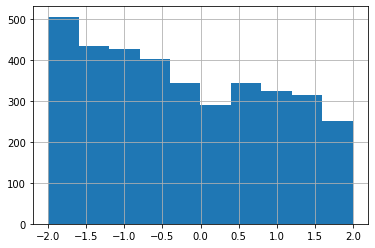

In [4]:
df_cc.x.hist()

In [5]:
df_cc.x[0]

-1.9994476368271146

In [6]:
def r_parallel(h):
    #print(1)
    def fn(j):
        df1 = df.drop([j],axis=0)
        y_hat = df.omega[j]*nw_mis(h,df.x[j],df1.x,df1.y,pi(df1.y,b0,b1),df1.omega)
        return (df.omega[j]/pi(df.y[j],b0,b1))*(df.y[j]-y_hat)**2

    with Pool(8) as p:
        return np.mean(p.map(fn, range(len(df))))

In [7]:
#r_parallel(0.001)

In [8]:
%%time
# r_parallel(0.1)
h_ipw = minimize(r_parallel, 0.1).x

CPU times: user 6.17 s, sys: 675 ms, total: 6.85 s
Wall time: 2min 40s


In [9]:
h_ipw

array([0.05293454])

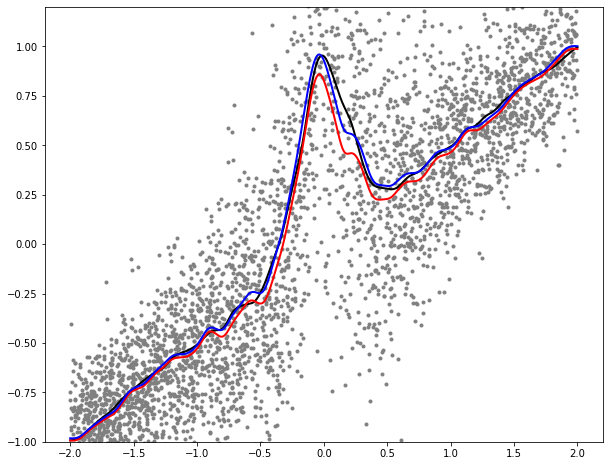

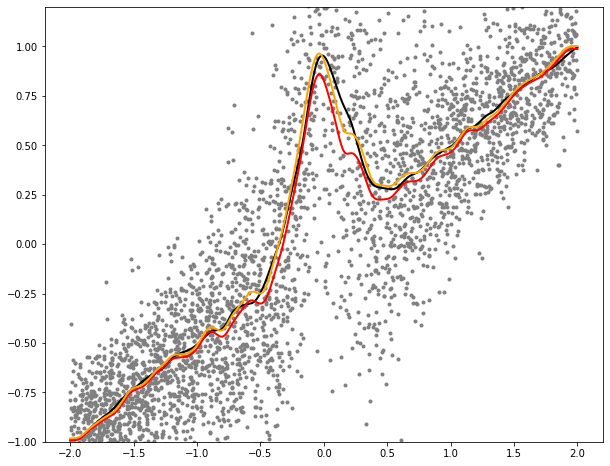

In [10]:
fig, ax = plt.subplots(1, 1,figsize=(10, 8))
#ax.plot(df['x'], df['y'], 'o', color='grey',markersize=2)

#First plot 

#Complete-cases
ax.plot(df_cc['x'], df_cc['y'], 'o', color='grey',markersize=3)
#Truth
ax.plot(np.linspace(-2, 2, n),model.fit(np.linspace(-2, 2, n))[0] ,color= 'black', lw=2)
#CC estimator 
ax.plot(np.linspace(-2, 2, n),model_cc.fit(np.linspace(-2, 2, n))[0] ,color= 'red', lw=2)
#CV bandwidth 
ax.plot(np.linspace(-2, 2, n),[nw_mis(h_ipw,t,X,y,pi(y,b0,b1),omega) for t in np.linspace(-2, 2, n)],color= 'blue', lw=2)

ax.set_ylim(-1,1.2)

plt.savefig(f'Fixed Cross-Validated Regression 1.pdf',transparent=True)


#Second plot 

fig, ax = plt.subplots(1, 1,figsize=(10, 8))

ax.plot(df_cc['x'], df_cc['y'], 'o', color='grey',markersize=3)
#Truth
ax.plot(np.linspace(-2, 2, n),model.fit(np.linspace(-2, 2, n))[0] ,color= 'black', lw=2,)
#CC estimator 
ax.plot(np.linspace(-2, 2, n),model_cc.fit(np.linspace(-2, 2, n))[0] ,color= 'red', lw=2)
#CC bandwidth 
ax.plot(np.linspace(-2, 2, n),[nw_mis(model_cc.bw,t,X,y,pi(y,b0,b1),omega) for t in np.linspace(-2, 2, n)],color= 'orange', lw=2)

#Sanity check
#ax.plot(np.linspace(-2, 2, n),[nw_cc(model_cc.bw,t,X,y,pi(y,b0,b1),omega) for t in np.linspace(-2, 2, n)],color= 'black', lw=2)

ax.set_ylim(-1,1.2)


plt.savefig(f'Fixed Cross-Validated Regression 2.pdf',transparent=True)




In [11]:
h_ipw

array([0.05293454])

In [12]:
model.bw

array([0.04488273])

In [13]:
model_cc.bw

array([0.05109688])

In [14]:
#df.to_csv('simulation.csv')

In [15]:
df['res'] = df['y'] - model.fit(df['x'])[0]



In [16]:
df_cc['res_cc'] = df_cc['y'] - model.fit(df_cc['x'])[0]

In [17]:
df_cc['res_ipw'] = df_cc['y'] - df_cc['x'].apply(lambda t:nw_mis(h_ipw,t,X,y,pi(y,b0,b1),omega))

In [18]:
df_cc['res_ipw_hcc'] = df_cc['y'] - df_cc['x'].apply(lambda t:nw_mis(model_cc.bw,t,X,y,pi(y,b0,b1),omega))

In [19]:
df[['res']].describe()

,res
count,10000.000000
mean,-0.000067
std,0.348495
min,-1.836701
25%,-0.194248
50%,-0.001932
75%,0.194012
max,1.921606


<Axes: >

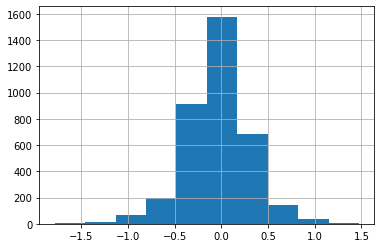

In [20]:
df_cc.res_cc.hist()

<Axes: >

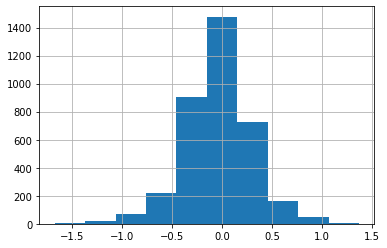

In [21]:
df_cc.res_ipw.hist()

In [22]:
#PriestleyChaokernel(x, y, h = 2, gridpoint = seq(-3,3,length.out=100))

In [23]:
df.to_csv('simulation.csv')

In [24]:
df_cc.to_csv('simulation_cc.csv')

In [25]:
df_cc

,x,y,omega,y_pi,var,res_cc,res_ipw,res_ipw_hcc
0,-1.999448,-1.033418,1,-2.049713,0.200135,-0.040656,-0.051110,-0.051100
1,-1.999435,-0.789517,1,-1.666653,0.200135,0.203245,0.192793,0.192803
2,-1.998307,-0.748869,1,-1.597928,0.200136,0.243840,0.233489,0.233517
3,-1.996869,-0.830731,1,-1.734832,0.200138,0.161908,0.151684,0.151735
4,-1.996721,-1.177614,1,-2.255156,0.200138,-0.184982,-0.195193,-0.195139
...,...,...,...,...,...,...,...,...
3635,1.991786,1.060858,1,4.033665,0.200143,0.067645,0.059179,0.059100
3636,1.992118,1.322221,1,5.544706,0.200143,0.328867,0.320557,0.320484
3637,1.992415,0.932568,1,3.383506,0.200143,-0.060911,-0.069082,-0.069151
3638,1.993890,0.573664,1,1.833674,0.200141,-0.420436,-0.427917,-0.427963
